# Gumbel Noise Experiment

This notebook demonstrates how Gumbel noise affects index selection in Wav2Vec2's quantization process.

We'll:
1. Create a random base vector (logits)
2. Add different Gumbel noise 100 times
3. See which index is selected via argmax in each iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)

## 1. Create Base Vector (Logits)

This represents the similarity scores between a feature and codebook entries

In [2]:
# Create a random base vector (e.g., 10 codebook entries)
codebook_size = 10
base_vector = np.random.randn(codebook_size) * 2  # Random logits

print("Base Vector (Logits):")
for i, val in enumerate(base_vector):
    print(f"  Index {i}: {val:.4f}")

# Without noise, the max index would be:
deterministic_max = np.argmax(base_vector)
print(f"\nDeterministic argmax (no noise): Index {deterministic_max}")

Base Vector (Logits):
  Index 0: 0.9934
  Index 1: -0.2765
  Index 2: 1.2954
  Index 3: 3.0461
  Index 4: -0.4683
  Index 5: -0.4683
  Index 6: 3.1584
  Index 7: 1.5349
  Index 8: -0.9389
  Index 9: 1.0851

Deterministic argmax (no noise): Index 6


## 2. Gumbel Noise Sampling Function

Standard Gumbel distribution: G = -log(-log(U)) where U ~ Uniform(0,1)

In [3]:
def sample_gumbel(shape):
    """
    Sample from Gumbel(0, 1) distribution.
    This is the same Gumbel noise used in Wav2Vec2.
    """
    uniform = np.random.uniform(0, 1, shape)
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    gumbel = -np.log(-np.log(uniform + epsilon) + epsilon)
    return gumbel

## 3. Add Gumbel Noise 100 Times and Record Selected Indices

In [4]:
num_iterations = 100
selected_indices = []

print("Running 100 iterations with different Gumbel noise...\n")
print("Iteration | Selected Index | Max Value After Noise")
print("-" * 55)

for i in range(num_iterations):
    # Sample fresh Gumbel noise for each iteration
    gumbel_noise = sample_gumbel(codebook_size)
    
    # Add noise to base vector
    noisy_vector = base_vector + gumbel_noise
    
    # Get the index with maximum value
    selected_idx = np.argmax(noisy_vector)
    max_val = noisy_vector[selected_idx]
    
    selected_indices.append(selected_idx)
    
    # Print first 20 iterations in detail
    if i < 20:
        print(f"{i+1:9d} | {selected_idx:14d} | {max_val:22.4f}")

print("\n... (showing first 20 iterations)")
print(f"\nTotal iterations: {num_iterations}")

Running 100 iterations with different Gumbel noise...

Iteration | Selected Index | Max Value After Noise
-------------------------------------------------------
        1 |              6 |                 3.8692
        2 |              9 |                 4.0327
        3 |              0 |                 4.3466
        4 |              6 |                 6.6358
        5 |              6 |                 3.2150
        6 |              3 |                 4.5584
        7 |              6 |                 5.0742
        8 |              3 |                 3.8443
        9 |              3 |                 3.2089
       10 |              3 |                 4.3179
       11 |              6 |                 4.7007
       12 |              3 |                 4.9434
       13 |              6 |                 6.4214
       14 |              6 |                 5.4996
       15 |              0 |                 5.2302
       16 |              6 |                 4.1020
      

## 4. Analyze the Distribution of Selected Indices

In [5]:
# Count how many times each index was selected
index_counts = Counter(selected_indices)

print("\nFrequency of Selected Indices:")
print("=" * 40)
for idx in range(codebook_size):
    count = index_counts.get(idx, 0)
    percentage = (count / num_iterations) * 100
    bar = '█' * int(percentage / 2)  # Visual bar
    print(f"Index {idx}: {count:3d} times ({percentage:5.1f}%) {bar}")

print(f"\nDeterministic max (no noise): Index {deterministic_max}")
print(f"Most frequently selected with noise: Index {max(index_counts, key=index_counts.get)}")


Frequency of Selected Indices:
Index 0:   6 times (  6.0%) ███
Index 1:   1 times (  1.0%) 
Index 2:   4 times (  4.0%) ██
Index 3:  40 times ( 40.0%) ████████████████████
Index 4:   0 times (  0.0%) 
Index 5:   0 times (  0.0%) 
Index 6:  32 times ( 32.0%) ████████████████
Index 7:  12 times ( 12.0%) ██████
Index 8:   0 times (  0.0%) 
Index 9:   5 times (  5.0%) ██

Deterministic max (no noise): Index 6
Most frequently selected with noise: Index 3


## 5. Visualize the Results

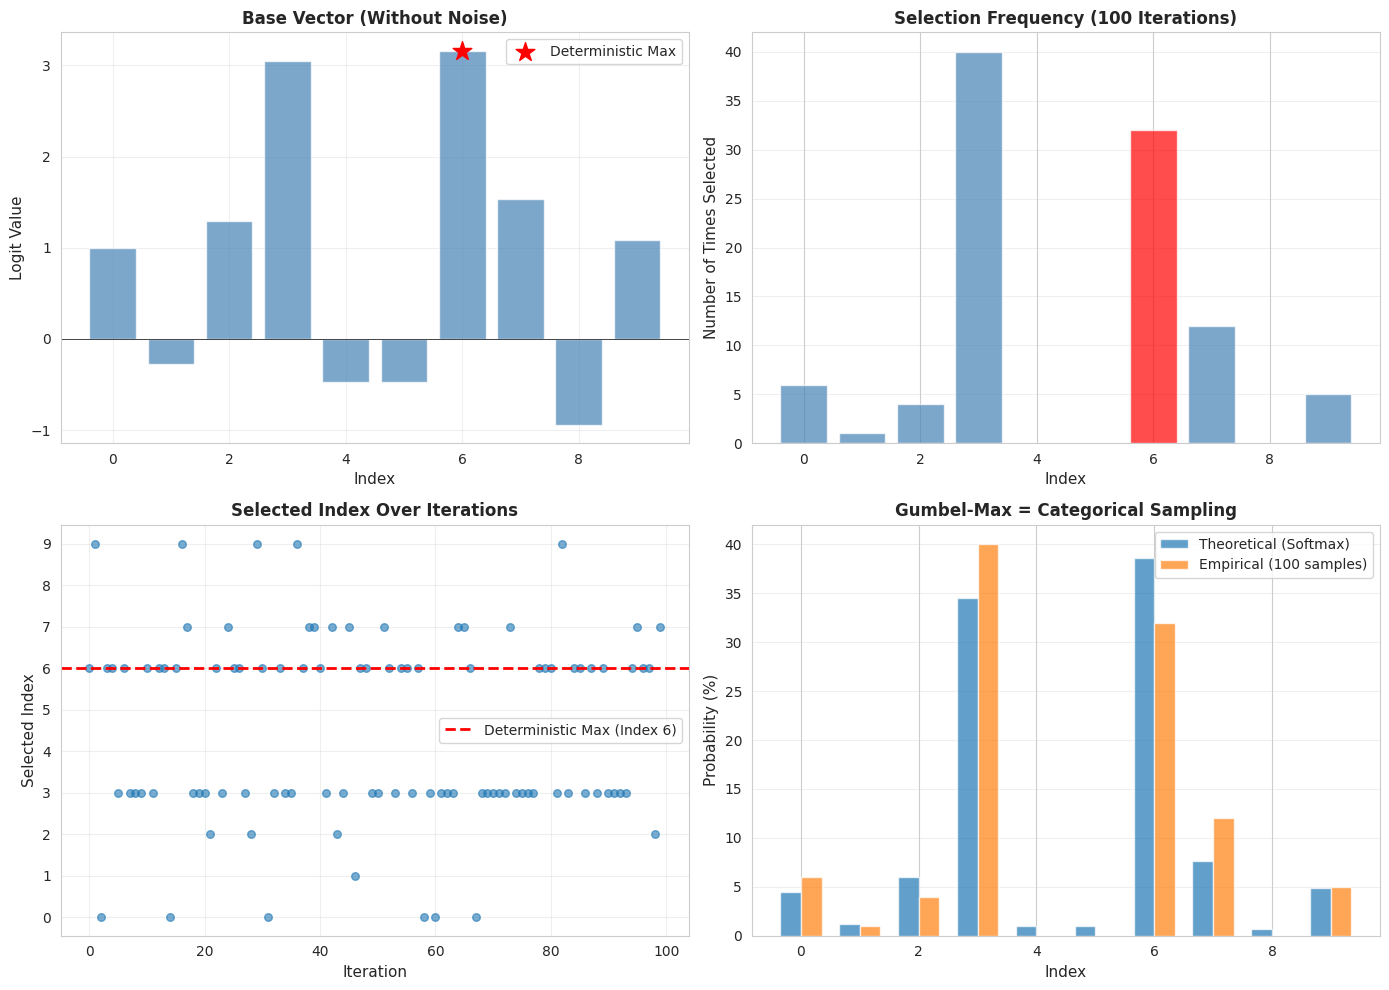


KEY INSIGHT: Gumbel-Max Trick
Adding Gumbel noise + argmax is equivalent to sampling from
a categorical distribution with probabilities = softmax(logits)

Notice how the empirical frequencies match the theoretical!


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Base vector values
axes[0, 0].bar(range(codebook_size), base_vector, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0, 0].scatter([deterministic_max], [base_vector[deterministic_max]], 
                   color='red', s=200, marker='*', zorder=5, label='Deterministic Max')
axes[0, 0].set_xlabel('Index', fontsize=11)
axes[0, 0].set_ylabel('Logit Value', fontsize=11)
axes[0, 0].set_title('Base Vector (Without Noise)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Frequency of selected indices
indices = list(range(codebook_size))
counts = [index_counts.get(i, 0) for i in indices]
colors = ['red' if i == deterministic_max else 'steelblue' for i in indices]
axes[0, 1].bar(indices, counts, color=colors, alpha=0.7)
axes[0, 1].set_xlabel('Index', fontsize=11)
axes[0, 1].set_ylabel('Number of Times Selected', fontsize=11)
axes[0, 1].set_title('Selection Frequency (100 Iterations)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Selection over iterations (first 100)
axes[1, 0].scatter(range(len(selected_indices)), selected_indices, alpha=0.6, s=30)
axes[1, 0].axhline(y=deterministic_max, color='red', linestyle='--', 
                   linewidth=2, label=f'Deterministic Max (Index {deterministic_max})')
axes[1, 0].set_xlabel('Iteration', fontsize=11)
axes[1, 0].set_ylabel('Selected Index', fontsize=11)
axes[1, 0].set_title('Selected Index Over Iterations', fontsize=12, fontweight='bold')
axes[1, 0].set_yticks(range(codebook_size))
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Theoretical vs Empirical probabilities
# Gumbel-Max trick: probability of selecting index i is softmax(logits)[i]
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Numerical stability
    return exp_x / exp_x.sum()

theoretical_probs = softmax(base_vector) * 100  # Convert to percentage
empirical_probs = np.array([index_counts.get(i, 0) / num_iterations * 100 for i in range(codebook_size)])

x = np.arange(codebook_size)
width = 0.35
axes[1, 1].bar(x - width/2, theoretical_probs, width, label='Theoretical (Softmax)', alpha=0.7)
axes[1, 1].bar(x + width/2, empirical_probs, width, label='Empirical (100 samples)', alpha=0.7)
axes[1, 1].set_xlabel('Index', fontsize=11)
axes[1, 1].set_ylabel('Probability (%)', fontsize=11)
axes[1, 1].set_title('Gumbel-Max = Categorical Sampling', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHT: Gumbel-Max Trick")
print("="*60)
print("Adding Gumbel noise + argmax is equivalent to sampling from")
print("a categorical distribution with probabilities = softmax(logits)")
print("\nNotice how the empirical frequencies match the theoretical!")
print("="*60)

## 6. Example with One Iteration (Detailed View)

In [7]:
# Show one detailed example
print("\n" + "="*60)
print("DETAILED EXAMPLE: One Iteration")
print("="*60)

gumbel_sample = sample_gumbel(codebook_size)
noisy = base_vector + gumbel_sample
selected = np.argmax(noisy)

print("\nIndex | Base Logit | Gumbel Noise | Noisy Logit | Selected?")
print("-" * 70)
for i in range(codebook_size):
    marker = " <-- MAX" if i == selected else ""
    print(f"{i:5d} | {base_vector[i]:10.4f} | {gumbel_sample[i]:12.4f} | {noisy[i]:11.4f} | {marker}")

print(f"\n✓ Index {selected} was selected in this iteration")


DETAILED EXAMPLE: One Iteration

Index | Base Logit | Gumbel Noise | Noisy Logit | Selected?
----------------------------------------------------------------------
    0 |     0.9934 |       1.0534 |      2.0469 | 
    1 |    -0.2765 |       2.5550 |      2.2785 | 
    2 |     1.2954 |      -0.5374 |      0.7579 | 
    3 |     3.0461 |       0.5696 |      3.6157 | 
    4 |    -0.4683 |       2.4270 |      1.9587 | 
    5 |    -0.4683 |      -1.2188 |     -1.6870 | 
    6 |     3.1584 |       1.0206 |      4.1791 | 
    7 |     1.5349 |      -0.1930 |      1.3419 | 
    8 |    -0.9389 |       2.5432 |      1.6043 | 
    9 |     1.0851 |       3.5278 |      4.6129 |  <-- MAX

✓ Index 9 was selected in this iteration


## 7. Wav2Vec2 Context: How This Works in Training

In Wav2Vec2:
- Each timestep has logits (similarities to codebook entries)
- Fresh Gumbel noise is added to each timestep's logits in each forward pass
- This allows differentiable sampling during training
- At inference, no noise is added (deterministic argmax)

The temperature parameter τ controls the "sharpness":
- τ → 0: More deterministic (picks highest logit)
- τ → ∞: More uniform (all indices equally likely)

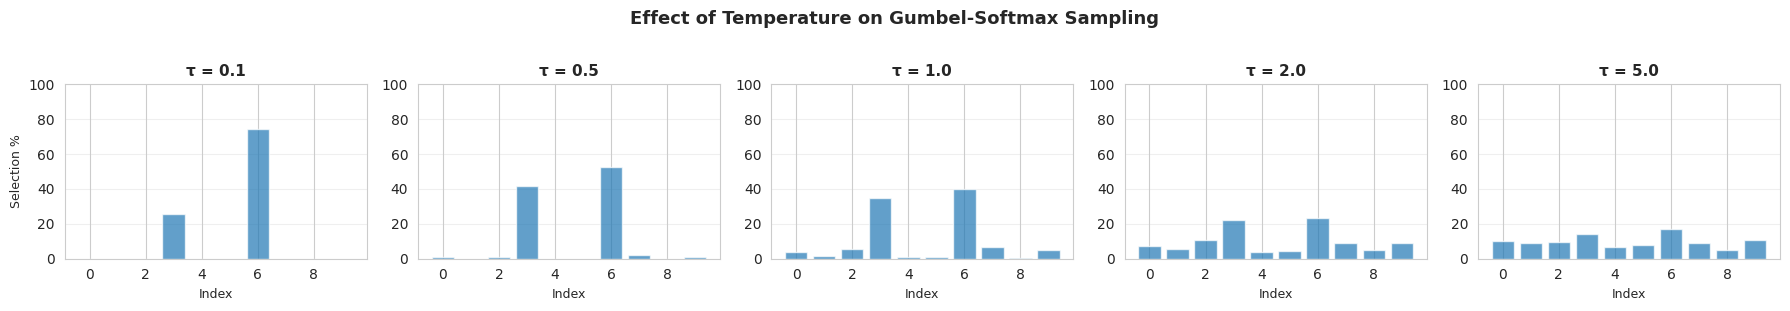


Observation:
- Low temperature (0.1): Almost always picks the highest logit
- High temperature (5.0): More uniform distribution across indices


In [8]:
# Experiment with different temperatures
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]
num_samples = 1000

fig, axes = plt.subplots(1, len(temperatures), figsize=(18, 3))

for idx, temp in enumerate(temperatures):
    selected = []
    for _ in range(num_samples):
        gumbel = sample_gumbel(codebook_size)
        # Apply temperature scaling
        noisy = (base_vector / temp) + gumbel
        selected.append(np.argmax(noisy))
    
    counts = Counter(selected)
    probs = [counts.get(i, 0) / num_samples * 100 for i in range(codebook_size)]
    
    axes[idx].bar(range(codebook_size), probs, alpha=0.7)
    axes[idx].set_title(f'τ = {temp}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Index', fontsize=9)
    axes[idx].set_ylim([0, 100])
    if idx == 0:
        axes[idx].set_ylabel('Selection %', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Effect of Temperature on Gumbel-Softmax Sampling', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nObservation:")
print("- Low temperature (0.1): Almost always picks the highest logit")
print("- High temperature (5.0): More uniform distribution across indices")